In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from wgan import FE, Discriminator, Classifier, Wasserstein_Loss, Grad_Loss
from tqdm import tqdm
import os
from scipy import io
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

In [2]:
import os
os.getcwd()

'/home/hun/바탕화면/AAI/DRDA_Wasserstein_Loss'

In [3]:
log = open("log.txt", "w")
print("DRDA_Wasserstein_Loss\n", file=log)
log.close()

In [4]:
def printsave(*a, end='\n') :
    print(*a, end=end)
    log = open("log.txt", "a")
    print(*a, file=log, end=end)
    log.close()

In [5]:
# path
path = r'../data_preprocessed_matlab/'  # 경로는 저장 파일 경로
file_list = os.listdir(path)

printsave("data path check")
for i in file_list:    # 확인
    printsave(i, end=' ')


for i in tqdm(file_list, desc="read data"): 
    mat_file = io.loadmat(path+i)
    data = mat_file['data']
    labels = np.array(mat_file['labels'])
    val = labels.T[0].round().astype(np.int8)
    aro = labels.T[1].round().astype(np.int8)
    
    if(i=="s05.mat"): 
        Data = data
        VAL = val
        ARO = aro
        continue
        
    Data = np.concatenate((Data ,data),axis=0)   # 밑으로 쌓아서 하나로 만듬
    VAL = np.concatenate((VAL ,val),axis=0)
    ARO = np.concatenate((ARO ,aro),axis=0)

data path check
s05.mat s08.mat s17.mat s07.mat s06.mat s27.mat s22.mat s10.mat s25.mat s20.mat s16.mat s15.mat s21.mat s03.mat s02.mat s31.mat s11.mat s12.mat s32.mat s13.mat s29.mat s09.mat s28.mat s01.mat s30.mat s14.mat s19.mat s26.mat s04.mat s18.mat s24.mat s23.mat 

read data: 100%|██████████| 32/32 [00:20<00:00,  1.58it/s]


In [6]:
# eeg preprocessing

eeg_data = []
peripheral_data = []

for i in tqdm(range(len(Data)), desc="preprocess channel"):
    for j in range (40): 
        if(j < 32): # get channels 1 to 32
            eeg_data.append(Data[i][j])
        else:
            peripheral_data.append(Data[i][j])

# set data type, shape
eeg_data = np.reshape(eeg_data, (len(Data),1,32, 8064))
eeg_data = eeg_data.astype('float32')
eeg_data32 = torch.from_numpy(eeg_data)
VAL = (torch.from_numpy(VAL)).type(torch.long)

preprocess channel: 100%|██████████| 1280/1280 [00:00<00:00, 130340.11it/s]


In [7]:
#data 40 x 40 x 8064 video/trial x channel x data
#labels 40 x 4 video/trial x label (valence, arousal, dominance, liking)
#32명 -> 12 / 12 / 8

# data split
printsave("data split")
train_data, val_data,train_label, val_label = train_test_split(eeg_data32, VAL, test_size=0.25)
x_train, x_test, y_train, y_test = train_test_split(train_data, train_label, test_size=0.5)

# make data loader
printsave("make data loader")
target_dataset = TensorDataset(x_train, y_train)
source_dataset = TensorDataset(x_test, y_test)
val_dataset = TensorDataset(val_data, val_label)
target_dataloader = DataLoader(target_dataset, 64, shuffle=True)
source_dataloader = DataLoader(source_dataset, 64, shuffle=True)
val_dataloader = DataLoader(val_dataset, 64, shuffle=True)

data split
make data loader


In [8]:
# cuda
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
printsave("device: ", device)

#model
dis = Discriminator(15960).to(device)
fe = FE(32).to(device)
classifier = Classifier().to(device)

#optim
optimizer_dis = optim.Adam(dis.parameters(),lr=0.0001,betas=(0,0.9))
optimizer_fe = optim.Adam(fe.parameters(),lr=0.0001, betas=(0,0.0))
optimizer_cls = optim.Adam(classifier.parameters(),lr=0.0001, betas=(0,0.9))

#cls_loss
criterion = nn.CrossEntropyLoss().to(device)

device:  cuda:0


1 : epoch

gloss -93.97523498535156
wd_loss 0.0971798524260521
cls_loss 2.0987510681152344
acc_t 0.18359375
acc_s 0.283203125
val_loss : 2.2144378662109374
acc_val : 0.165625

2 : epoch

gloss -89.26289367675781
wd_loss 0.19814808666706085
cls_loss 2.0504350662231445
acc_t 0.1875
acc_s 0.3125
val_loss : 2.2134406566619873
acc_val : 0.165625

3 : epoch

gloss -85.90918731689453
wd_loss 0.2731785774230957
cls_loss 2.0081326961517334
acc_t 0.18359375
acc_s 0.34765625
val_loss : 2.2127973079681396
acc_val : 0.16875

4 : epoch

gloss -88.25518035888672
wd_loss 0.30877742171287537
cls_loss 1.9866516590118408
acc_t 0.18359375
acc_s 0.365234375
val_loss : 2.2132155418396
acc_val : 0.16875

5 : epoch

gloss -79.86189270019531
wd_loss 0.39201751351356506
cls_loss 1.9552677869796753
acc_t 0.189453125
acc_s 0.40234375
val_loss : 2.2097919464111326
acc_val : 0.171875

accuracy_t  tensor(0.1855, device='cuda:0')
accuracy_s  tensor(0.3422, device='cuda:0')
accuracy_val 0.168125
best_val_loss  2.20979

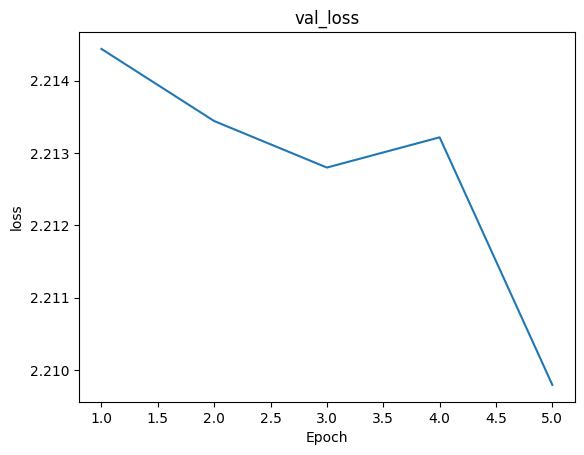

In [9]:
# train WGAN
accuracy_s = []
accuracy_t = []
accuracy_val = []
val_loss_list = []

best_loss = 10000000
limit_epoch = 100
limit_check = 0
val_loss = 0
nb_epochs = 5
lambda_hyper = 10
mu_hyper = 10
n = 5

torch.autograd.set_detect_anomaly(True)

epochs = 0
printsave()
# while parameter converge
for epoch in range(nb_epochs):
    temp_accuracy_t = 0
    temp_accuracy_s = 0
    temp_accuracy_val = 0
    temp_gloss = 0
    temp_wdloss = 0
    temp_gradloss = 0
    temp_clsloss = 0

    printsave(epoch+1, ": epoch")

    temp = 0.0 #batch count
    fe.train()
    dis.train()
    classifier.train()
    # batch
    for i, (target, source) in enumerate(zip(target_dataloader, source_dataloader)):
        temp += 1.0

        x_target = target[0].to(device)
        y_target = target[1].to(device)
        x_source = source[0].to(device)
        y_source = source[1].to(device)

        # update discriminator
        for p in fe.parameters() :
            p.requires_grad = False
        for p in dis.parameters() :
            p.requires_grad = True
        for p in classifier.parameters() :
            p.requires_grad = False
        
        for k in range(n) :
            optimizer_dis.zero_grad()
            wd_grad_loss = 0
            feat_t = fe(x_target)
            feat_s = fe(x_source)
            pred_t = classifier(feat_t)
            pred_s = classifier(feat_s)
            for j in range(feat_s.size(0)) :
                epsil = torch.rand(1).item()
                feat = epsil*feat_s[j,:]+(1-epsil)*feat_t[j,:]
                dc_t = dis(feat_t)
                dc_s = dis(feat_s)
                wd_loss = Wasserstein_Loss(dc_s, dc_t)
                grad_loss = Grad_Loss(feat, dis, device)
                wd_grad_loss = wd_grad_loss - (wd_loss-lambda_hyper*grad_loss)
            wd_grad_loss = wd_grad_loss / feat_s.size(0)
            wd_grad_loss.backward()
            optimizer_dis.step()

        # update classifier
        for p in fe.parameters() :
            p.requires_grad = False
        for p in dis.parameters() :
            p.requires_grad = False
        for p in classifier.parameters() :
            p.requires_grad = True
        
        optimizer_cls.zero_grad()
        feat_s = fe(x_source)
        pred_s = classifier(feat_s)
        cls_loss_source = criterion(pred_s, y_source-1)
        cls_loss_source.backward()
        optimizer_cls.step()
        
        # update Feature Extractor
        for p in fe.parameters() :
            p.requires_grad = True
        for p in dis.parameters() :
            p.requires_grad = False
        for p in classifier.parameters() :
            p.requires_grad = False
        
        optimizer_fe.zero_grad()
        feat_t = fe(x_target)
        feat_s = fe(x_source)
        pred_s = classifier(feat_s)
        dc_t = dis(feat_t)
        dc_s = dis(feat_s)
        wd_loss = Wasserstein_Loss(dc_s, dc_t)
        cls_loss_source = criterion(pred_s, y_source-1)
        fe_loss = cls_loss_source + mu_hyper*wd_loss
        fe_loss.backward()
        optimizer_fe.step()
        
        # Temp_Loss
        wd_loss = Wasserstein_Loss(dc_s, dc_t)
        cls_loss_source = criterion(pred_s, y_source-1)
        g_loss = cls_loss_source + mu_hyper*(wd_loss - lambda_hyper*grad_loss)

        feat_t = fe(x_target)
        feat_s = fe(x_source)
        pred_t = classifier(feat_t)
        pred_s = classifier(feat_s)
        
        temp_wdloss = temp_wdloss + wd_loss
        temp_clsloss = temp_clsloss + cls_loss_source
        temp_gloss = temp_gloss + g_loss

        temp_accuracy_t += ((torch.argmax(pred_t,1)+1)== y_target).to(torch.float).mean()
        temp_accuracy_s += ((torch.argmax(pred_s,1)+1)== y_source).to(torch.float).mean()
    
    printsave("\ngloss", temp_gloss.item()/temp)
    printsave("wd_loss", temp_wdloss.item()/temp)
    printsave("cls_loss", temp_clsloss.item()/temp)
    printsave("acc_t", temp_accuracy_t.item()/temp)
    printsave("acc_s", temp_accuracy_s.item()/temp)
    
    accuracy_t.append(temp_accuracy_t/temp)
    accuracy_s.append(temp_accuracy_s/temp)
    
    fe.eval()
    dis.eval()
    classifier.eval()
    val_loss = 0
    temp = 0
    for x_val, y_val in val_dataloader:
        x_val = x_val.to(device)
        y_val = y_val.to(device)
        pred_val = classifier(fe(x_val))
        temp_accuracy_val += ((torch.argmax(pred_val,1)+1)== y_val).to(torch.float).mean()
        loss = criterion(pred_val, y_val-1)
        val_loss += loss.item() * x_val.size(0)
        temp += 1
    val_total_loss = val_loss / len(val_dataloader.dataset)
    val_loss_list.append(val_total_loss)
    printsave("val_loss :", val_total_loss)
    printsave("acc_val :", temp_accuracy_val.item()/temp)
    accuracy_val.append(temp_accuracy_val.item()/temp)
    epochs = epochs + 1
    if val_total_loss > best_loss:
        limit_check += 1
        if(limit_check >= limit_epoch):
            break
    else:
        best_loss = val_total_loss
        limit_check = 0
    printsave()

printsave("accuracy_t ", sum(accuracy_t)/len(accuracy_t))
printsave("accuracy_s ", sum(accuracy_s)/len(accuracy_s))
printsave("accuracy_val", sum(accuracy_val)/len(accuracy_val))
printsave("best_val_loss ", best_loss)

plt.title('val_loss')
plt.plot(np.arange(1, epochs+1, 1), val_loss_list, label='val')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.savefig('save_val_loss.png')